In [25]:
# Prep training data
from copyreg import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import sys
from tkinter import Y
import gzip
import itertools
import numpy as np
import pandas as pd
import pickle as pk
import torch
import gpytorch
import plotly.express as px
import matplotlib.pyplot as plt
sys.path.append('..')
sys.path.insert(0, '../src')

In [26]:
from model import GPModel
from GPy.models import GPRegression
from acq_funcs import EI, PI, cust_acq, thompson
from plotter import vis_pred, vis_acq

### Data Read and Pre-processing

In [27]:
# read data and display
def read_dat(dir="/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/",
            src_file = "Bolometer_readings_PulseForge.xlsx", sheet= "Combined"):
    file = dir + src_file
    fe_data = pd.read_excel(file, sheet_name=sheet, usecols=['Energy density new cone (J/cm^2)',
                            'Time (ms)','2 Qsw/(U+|D|) 1e6cycles'])
    fe_data.dropna(subset=['2 Qsw/(U+|D|) 1e6cycles'], inplace=True)
    fe_data = fe_data[fe_data['2 Qsw/(U+|D|) 1e6cycles']!= 0]
    return fe_data

def display_data(fe_data):
    """
    [display_data(fe_data)] creates a cross-section scatter plot of all combinations
    of the four input parameters and single output parameter.
    """
    # plot each cross-section
    fig = px.scatter_matrix(fe_data, dimensions=['Energy density new cone (J/cm^2)', 
    "Time (ms)", "2 Qsw/(U+|D|) 1e6cycles"])
    fig.update_layout(margin=dict(r=20, l=10, b=10, t=10))
    fig.update_layout(height=1000)
    fig.show()

In [28]:
# get training set from dataframe
def datasetmaker(fe_data):
    """
    [datasetmaker(fe_data)] filters and transforms the data in pandas df [fe_data] 
    into two tensors, [train_x] for input and [train_y] for output tensors. 
    """
    # define standardizer
    norm_arr = lambda arr, min, max: (arr - min)/(max - min)
    
    # filter training data 
    energy_den = fe_data['Energy density new cone (J/cm^2)'].values
    time = fe_data['Time (ms)'].values
    train_x = torch.Tensor([energy_den, time]).T
    train_y = torch.Tensor(fe_data['2 Qsw/(U+|D|) 1e6cycles'].values)

    # standardizer inputs; x_min, x_max are min/max per column (parameter) of x
    x_min, _ = torch.min(train_x, dim=0)
    x_max, _ = torch.max(train_x, dim=0)
    train_x = norm_arr(train_x, x_min, x_max)

    # standardizer outputs
    y_sd_mean = torch.std_mean(train_y, axis=0)
    # train_y = norm_arr(train_y, y_sd_mean[1], y_sd_mean[0])
    
    # return x_sd_mean, y_sd_mean, train_x, train_y
    return x_min, x_max, train_x, train_y

In [29]:
# undo normalization
def un_norm(arr, min, max): return arr*(max - min) + min

def un_norm_all(x_min, x_max, train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf):
    raw_train_x = un_norm(train_x, x_min, x_max)
    raw_test_grid = un_norm(test_grid, x_min, x_max)

    return raw_train_x, train_y, raw_test_grid, pred_labels, upper_surf, lower_surf

In [30]:
fe_data = read_dat()
print(fe_data)

    Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6cycles
4         0.5                              2.73                 0.873026
5         0.5                              3.40                 2.677245
6         1.0                              3.79                 1.699015
7         1.0                              6.44                 3.805053
8         1.5                              5.36                 3.334856
9         1.5                              8.99                 4.535153
11        5.0                              8.80                 1.362510
13        5.0                             14.67                 3.841291
19        0.5                              5.24                 1.201357
22        5.0                             14.89                 3.513652
23        2.0                             10.13                 3.470871
24        0.5                              4.51                 0.263298
25        0.5                              5.37    

In [31]:
display_data(fe_data)

In [32]:
# make training data, maintain params to de-normalize
# x_sd_mean, y_sd_mean, train_x, train_y = datasetmaker(fe_data)
x_min, x_max, train_x, train_y = datasetmaker(fe_data)

### Grid/Parameter Space

In [33]:
# create grid for grid search
def grid_helper(grid_size, num_params, grid_bounds):
    """
    [grid_helper(grid_size, num_params, grid_bounds)] returns a grid of dimensions
    [grid_size] by [num_params], which dictates the parameter space for GP to be 
    conducted over. 
    """
    grid = torch.zeros(grid_size, num_params)
    f_grid_diff = lambda i, x, y : float((x[i][1] - x[i][0]) / (y-2))
    for i in range(num_params):
        grid_diff = f_grid_diff(i, grid_bounds, grid_size)
        grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                    grid_bounds[i][1] + grid_diff, grid_size)
    return grid

def grid_maker(train_x, num_points=30):
    """
    [grid_maker(train_x, num_points=30)] creates grids to be used for gaussian 
    process predictions. It outputs the dimension of the grid [num_params], 
    paramater space grid [test_grid], and [test_x].
    """
    # define grid between bounds of RTA time, RTA temp
    num_params = train_x.size(dim=1)
    grid_bounds = [(train_x[:,i].min(), train_x[:,i].max()) for i in range(num_params)]

    # set up test_grid for predictions
    test_grid = grid_helper(num_points, num_params, grid_bounds)

    # create n-D grid with n = num_params
    args = (test_grid[:, i] for i in range(num_params))
    test_x = torch.cartesian_prod(*args)
    return grid_bounds, num_params, test_grid, test_x


In [34]:
# create grid based on parameter space for search
grid_bounds, num_params, test_grid, test_x = grid_maker(train_x)

### Noise Calculations

Our figure of merit, fom, is $2 Q_{sw}/(U+|D|),$ so error propagation would result in a error of $\sigma_{fom} = |fom|\sqrt{{(\sigma_{Q_{sw}}/Q_{sw}})^2+{(\sigma_U^2 + \sigma_{|D|}^2)/(U+|D|)^2)}}$. We have data for $2Pr$ measurements wrt device area. Using the $10\mu$ m $\times 10\mu$ m data, we approximate the error for the figure of merit as simply $\sigma_{2Pr}$, as we do not have $\sigma_U$ or $\sigma_D.$ 


In [35]:
fn = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/P vs area.xlsx"
excel_file = pd.read_excel(fn, sheet_name='Sheet1')
col_2Pr_10by10 = excel_file['10umx10um']
sd = col_2Pr_10by10.std()/col_2Pr_10by10.mean()
print(sd)
print(col_2Pr_10by10)

0.04469365441252401
0     34.57379
1     35.96416
2     33.16083
3     35.96861
4     37.10497
5     35.86549
6     35.81341
7     33.01597
8     35.71753
9     38.37434
10    34.11144
11    33.57596
12    35.15750
13    35.01515
14    36.01072
15    37.04952
16    36.48895
17    35.63807
18    37.36247
19    39.05057
Name: 10umx10um, dtype: float64


### Initialize Model

In [124]:
# configuration parameters for training
class Config():
    def __init__(self):
        self.epochs = 5000
        self.kernel = "matern"
        self.lr = 0.005
        self.lscale_1 = 0.4
        self.lscale_2 = 0.1
        self.lscale_3 = None
        self.lscale_4 = None
        self.dim = 2
        self.noise = 0.15

config = Config()

In [135]:
# make model
def kernel_func(config_kernel, num_params, lscale):
    """
    [kernel_func(config_kernel, num_params, lscale)] returns kernel function with 
    dimensions specified by [num_params]. 
    """
    if config_kernel == "rbf":
        return gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_params))
    elif config_kernel == "matern":
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=num_params, 
        lengthscale = torch.tensor(lscale), nu=0.5))

def make_model(train_x, train_y, num_params, config):
    """
    [make_model(train_x, train_y, num_params, config)] returns likelihood and 
    model with lengthscale, noise, kernel function specified by sweeps. 
    """
    
    if config.dim == 2:
        lscale = [config.lscale_1, config.lscale_2]
    elif config.dim == 4:
        lscale = [config.lscale_1, config.lscale_2, config.lscale_3, config.lscale_4]
    kernel = kernel_func(config.kernel, num_params, lscale)
    
    print(kernel)
    num_samples = len(train_x)
    noise = config.noise*torch.ones(num_samples)
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood, kernel)

    return likelihood, model, lscale
    

In [109]:
def intermediate_plot(f, ax, obs, title):
    im = ax.imshow(obs.mean.view(30, 30), aspect='equal',
                extent=[grid_bounds[0][0].item(), grid_bounds[0][1].item(),
                            grid_bounds[1][0].item(), grid_bounds[1][1].item()])
    f.colorbar(im)
    ax.set_title(title)

### GP Training and Eval

In [136]:
# training and evaluation
def train(train_x, train_y, num_params, config):
    likelihood, model, lscale = make_model(train_x, train_y, num_params, config)
    model.covar_module.base_kernel.lengthscale = torch.Tensor(lscale)
    training_iter = config.epochs
    model.covar_module.base_kernel.raw_lengthscale.requires_grad_(False) # disallow training of lengthscale
    
    # place both the model and likelihood in training mode
    model.train(), likelihood.train()

    # use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    # set GP loss as the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss_lst = []

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)

        # backpropagate error
        loss = -mll(output, train_y)
        loss.backward()

        if i % 100 == 0: 
            print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
                    i+1, training_iter, loss.item(), 
                    model.covar_module.base_kernel.lengthscale.detach().numpy(),
                    model.likelihood.noise.detach().numpy()
                    )) 
            loss_lst.append(loss.item())

        # if i % 1000 == 0:
        # # get a quick snapshot of intermediate 
        #     model.eval()
        #     likelihood.eval()
        #     with torch.no_grad(), gpytorch.settings.fast_pred_var():
        #         obs = likelihood(model(test_x))
        #         f, ax = plt.subplots(1, 1, figsize=(4,3))
        #         intermediate_plot(f, ax, obs, f'iter {i+1}/{training_iter}')
        #     model.train()
        #     likelihood.train()
        optimizer.step()
        
    print(model.covar_module.outputscale.detach().numpy())
    return likelihood, model, loss_lst

def eval_mod(likelihood, model, test_x):
    """ 
    [eval_mod(likelihood, model, test_x)] evaluates GP model. 
    """
    model.eval(), likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obs = likelihood(model(test_x), noise=(torch.ones(len(test_x))*config.noise))
    return obs

In [137]:
# train model and evaluate
likelihood, model, loss_lst = train(train_x, train_y, num_params, config)

obs = eval_mod(likelihood, model, test_x)

ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)
Iter 1/5000 - Loss: 3.397  lengthscale1: [[0.4 0.1]]   noise: [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
Iter 101/5000 - Loss: 2.906  lengthscale1: [[0.4 0.1]]   noise: [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
Iter 201/5000 - Loss: 2.675  lengthscale1: [[0.4 0.1]]   noise: [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
Iter 301/5000 - Loss: 2.549  lengthscale1: [[0.4 0.1]]   noise: [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
Iter 401/5000 - Loss: 2.475  lengthscale1: [[0.4 0.1]]   noise: [0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 

### GP Training Results

/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning:

The input matches the stored training data. Did you forget to call model.train()?



     Metric  Value
0      RMSE  0.591
1       MAE  0.447
2  Spearman  0.861
3  R² score  0.773


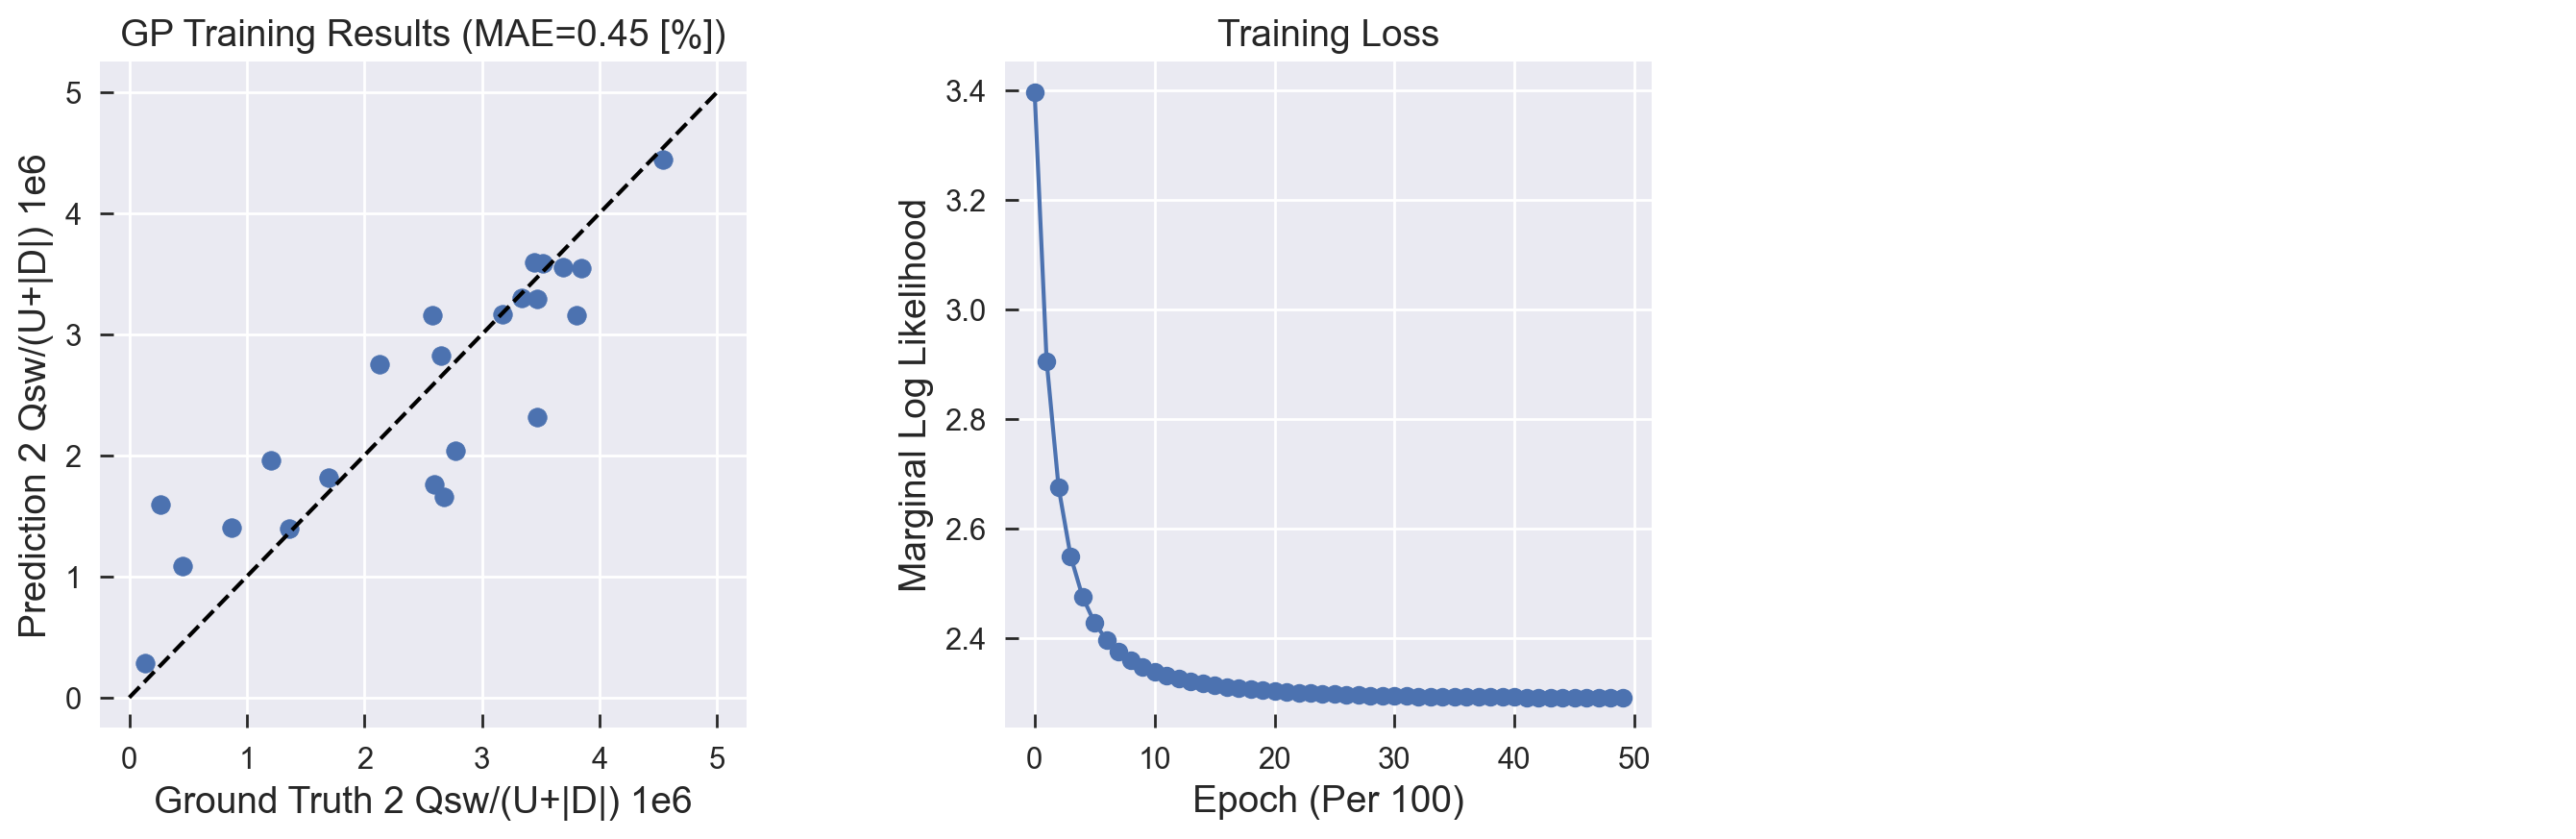

In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt 
from plotter import prettyplot

round_three = lambda val: np.round(val, 3) 
y_preds = likelihood(model(train_x))
prettyplot()

# plot training results
with torch.no_grad():
    y_preds_mean = y_preds.mean.numpy()
    fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
    fs = 14

    # calculate error metrics
    rmse = np.sqrt(mean_squared_error(train_y, y_preds_mean))
    mae = mean_absolute_error(train_y,  y_preds_mean)
    spearman = spearmanr(train_y, y_preds_mean)[0]
    r2 = r2_score(train_y, y_preds_mean)
    err_vals = [round_three(i) for i in [rmse, mae, spearman, r2]]

    # print error metrics
    data = {'Metric': ['RMSE', 'MAE', 'Spearman', 'R² score'], 'Value': err_vals}
    df = pd.DataFrame(data)
    print(df)

    # training versus actuals plot: make plot, set title and axes values
    axes[0].scatter(train_y, y_preds_mean)
    axes[0].plot(np.linspace(0, 5, 5), np.linspace(0, 5, 5), 'k--')
    axes[0].set_xlabel('Ground Truth 2 Qsw/(U+|D|) 1e6', fontsize = fs)
    axes[0].set_ylabel('Prediction 2 Qsw/(U+|D|) 1e6', fontsize = fs)
    axes[0].set_title('GP Training Results' + " (MAE=%.2f" % mae+' [%])', fontsize = fs)

    # loss plot: make plot, set title and axes values
    axes[1].plot(loss_lst, 'o-')
    title = 'Training Loss'
    axes[1].set_xlabel('Epoch (Per 100)', fontsize = fs)
    axes[1].set_ylabel('Marginal Log Likelihood', fontsize = fs)
    axes[1].set_title(title, fontsize = fs)
    axes[2].axis("off")

    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8)
    plt.subplots_adjust(wspace = 0.4)

    plt.show()

In [129]:
# acquisition function for prediction/exploration
def get_bounds(n): return [n for i in range(config.dim)]

def unravel_acq(acq_func, obs, bounds, train_y, nshape):
    """ 
    [unravel_acq(acq_func, obs, bounds, train_y, nshape)] is a helper function 
    for acq that returns the coordinates of the maximum value of the acq_func 
    over the test grid in the form of a tuple (row_index, column_index). 

    row_index = index into time
    column_index = index into energy density
    """
    acq = acq_func(obs, bounds, train_y).detach().numpy().reshape(nshape).T
    return np.unravel_index(acq.argmax(), acq.shape)

def acq(obs, train_y, bounds):
    """ 
    [acq(obs, train_y, bounds)] evaluates acquisition functions on current 
    predictions (observations) and outputs suggested points for exploration 
    on manifold. 
    """
    transpose = lambda tensor: tensor.detach().numpy().reshape(nshape).T
    nshape = tuple(bounds)

    pi = unravel_acq(PI, obs, bounds, train_y, nshape) # prob of improvement
    ei = unravel_acq(EI, obs, bounds, train_y, nshape) # expected improvement
    ca = unravel_acq(cust_acq, obs, bounds, train_y, nshape) # custom acq
    th = unravel_acq(thompson, obs, bounds, train_y, nshape) # thompson acq

    lower, upper = obs.confidence_region()
    upper_surf, lower_surf = transpose(upper), transpose(lower)
    ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)

    pred_var = obs.variance.view(nshape).detach().numpy().T
    pred_labels = obs.mean.view(nshape)
    max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)

    # acqs gives pairs corresponding to indices of time and energy density recommendations in grid
    # pairs index into pred_labels 
    acqs = {"PI":pi, "EI":ei, "CA":ca, "TH":th, "UCB":ucb, "Max_var":max_var}

    return pred_labels, upper_surf, lower_surf, acqs

In [130]:
# export predictions to csv
def pred_to_csv(acqs, raw_pred_labels, raw_test_grid, file_out = "preds.csv"):
    """
    [pred_to_csv(acqs, raw_pred_labels, raw_test_grid)] outputs suggested
    inputs and their respective predicted outputs to csv. 
    """   
    dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
    file = open(dir + file_out, "w", encoding="utf-8")
    file.write("Energy density \t Time (ms)\n")
    data = {'Time(ms)':[], 'Energy density new cone (J/cm^2)':[], '2 Qsw/(U+|D|) 1e6':[]}
    for lab, coords in acqs.items(): 
        time_val = raw_test_grid[coords[1]].tolist()[0]
        energy_den_val = raw_test_grid[coords[0]].tolist()[1]
        data['Time(ms)'].append(time_val)
        data['Energy density new cone (J/cm^2)'].append(energy_den_val)
        file.write(lab + ": " + str(time_val) + "\t" + str(energy_den_val) + "\n")

    file.write("\nFigure of merit\n")
    for lab, coords in acqs.items():
        fig_of_merit = raw_pred_labels[coords].item()
        data['2 Qsw/(U+|D|) 1e6'].append(fig_of_merit)
        file.write(lab + ": " + str(fig_of_merit) + "\n")

    df = pd.DataFrame(data)
    print(df)


In [131]:
# get normalized predictions
bounds = get_bounds(n=30)
pred_labels, upper_surf, lower_surf, acqs = acq(obs, train_y, bounds)

# undo normalization
raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels, raw_upper_surf, raw_lower_surf = un_norm_all(x_min, x_max, train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf)


### Save Predictions and Visualize 

In [132]:
# undo normalization and save to csv
pred_to_csv(acqs, raw_pred_labels, raw_test_grid)

    Time(ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6
0   8.850208                          1.503079           2.085421
1  10.728535                          1.336823           2.322422
2  13.076441                          3.664409           2.389179
3   8.850208                          3.830665           2.324258
4  13.076441                          1.336823           2.290671
5   2.276072                          3.498152           2.523788


In [133]:
# visualize acquisition function results and confidence bound surfaces
vis_pred(raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels)
vis_acq(raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels, raw_upper_surf, raw_lower_surf, acqs)

In [47]:
print(test_grid.shape)

torch.Size([30, 2])


In [134]:
y_preds_1 = likelihood(model(torch.Tensor([[2.9, 9.04]])))
with torch.no_grad():
    y_preds_mean_1 = y_preds_1.mean.numpy()
print(y_preds_mean_1)

[2.3957562]


/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.

